# Models
(arranjar um nome melhor para o notebook)

Notebook para o treinamento de modelos

In [2]:
import random
import pickle

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# models
import sklearn
import sktime
import keras
import statsmodels.api as sm
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from tensorflow import keras
from tensorflow.keras import layers

# model selection and metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

# constants
PROCESSED_DATA_PATH = '../data/processed-data/'
MODEL_PATH = '../models/trained-models/'
TARGET_COLS = ['target1', 'target2', 'target3', 'target4']
TEST_SPLIT_DATE = '2021-04-30'

# disable warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

2023-03-26 19:57:51.413744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 19:57:52.106740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-26 19:57:52.106753: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-26 19:57:53.682357: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Auxiliary Functions

In [3]:
def plot_time_series(df, groupby = 'median', cols = TARGET_COLS):
    df_melted = df.groupby('Dt').median()[cols]\
    .melt(var_name='target', value_name='value', ignore_index=False)
    df_melted.reset_index(inplace=True)

    sns.set(rc={'figure.figsize':(10,20)})
    sns.FacetGrid(df_melted, col='target', col_wrap=2, height=9,aspect=2, sharey=False)\
    .map(sns.lineplot, 'Dt', 'value');

In [4]:
def plot_train_test_pred(train, test, pred = pd.DataFrame(), groupby = 'median', cols = TARGET_COLS):
    train['type'] = 'train'
    test['type'] = 'test'
    pred['type'] = 'pred'
    
    cols.append('type')

    df = pd.concat([train, test, pred], axis=0)
    df_melted = df.groupby('Dt').median()[cols]\
        .melt(var_name='target', value_name='value', ignore_index=False)
    df_melted.reset_index(inplace=True)
    
    sns.set(rc={'figure.figsize':(10,20)})
    sns.FacetGrid(df_melted, col='target', col_wrap=2, height=9,aspect=2, sharey=False)\
        .map(sns.lineplot, 'Dt', 'value', hue='type');

## Data Preparation

Apenas realizar modificações necessárias para os modelos como *splitting* dos datasets e normalização. Toda a limpeza de dados deve ser feita em **/src/data-engineering/data-preparation**

### Loading the data

In [5]:
%%time
# df_targets = pd.read_pickle(PROCESSED_DATA_PATH + 'targets.pkl')

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [6]:
# df_targets

### Sorting by IdPlayer

In [7]:
# # sort by player then by date
# df_targets.sort_values(by=['IdPlayer', 'Dt'], inplace=True)
# # reset index
# df_targets.reset_index(drop=True, inplace=True)
# df_targets

In [8]:
# Example dataset
# df_targets = df_targets[df_targets['IdPlayer'].isin([112526, 685503, 628317])]
# df_targets

### Shifting

In [9]:
# %%time
# # Make the shifts for each target
# shift_vals = [1, 2, 3, 4, 5, 6, 7, 14, 30]
# df = pd.DataFrame()
# # Iterate over players to make the shift only using the player data
# for player in df_targets['IdPlayer'].unique():
#     df_player = df_targets[df_targets['IdPlayer'] == player]
#     # Iterate over the pre-defined shift values
#     for shift_val in shift_vals:
#         # Iterate over the targets
#         for target in TARGET_COLS:
#             # Make the shift
#             df_player[f'{target}_shift_{shift_val}'] = df_player[target].shift(shift_val)
#     # Concatenate the player data with the rest of the data
#     df = pd.concat([df, df_player], axis=0)
#     # Remove the player data from memory
#     del df_player
# # Remove the original targets from memory
# del df_targets

In [10]:
# df[df['IdPlayer'] == 628317].head(10)

In [11]:
# df[df['IdPlayer'] == 112526].head(5)

In [12]:
# pd.to_pickle(df, PROCESSED_DATA_PATH + 'shifted_targets.pkl')
df = pd.read_pickle(PROCESSED_DATA_PATH + 'shifted_targets.pkl')

### NaN handling

In [13]:
df.dropna(inplace=True)

### Train Test Split

In [14]:
# train test split
train = df[df['Dt'] <= '2021-04-30']
y_train = train[TARGET_COLS]
x_train = train.drop(TARGET_COLS, axis=1)
test = df[df['Dt'] > TEST_SPLIT_DATE]
y_test = test[TARGET_COLS]
x_test = test.drop(TARGET_COLS, axis=1)

In [15]:
train.shape

(2444346, 43)

In [16]:
test.shape

(189612, 43)

In [17]:
del df

### Data Normalization

## Training

### Baseline Models

#### Naive

In [18]:
def naive(test):
    y_pred = pd.DataFrame(columns=TARGET_COLS)
    for target in TARGET_COLS:
        y_pred[target] = test[target + '_shift_1']
    return y_pred

In [19]:
%%time
y_pred_naive = naive(test)
y_pred_naive.head(5)

CPU times: user 22.9 ms, sys: 0 ns, total: 22.9 ms
Wall time: 22 ms


,target1,target2,target3,target4
1216,0.009073,0.412742,0.020685,100.000000
1217,0.006267,0.643099,0.071587,100.000000
1218,0.011920,0.605747,0.036597,100.000000
1219,0.003875,0.488195,0.072502,44.480946
1220,0.004221,0.163703,0.018476,11.722289


In [20]:
test[TARGET_COLS].head(5)

,target1,target2,target3,target4
1216,0.006267,0.643099,0.071587,100.000000
1217,0.011920,0.605747,0.036597,100.000000
1218,0.003875,0.488195,0.072502,44.480946
1219,0.004221,0.163703,0.018476,11.722289
1220,0.007261,0.300970,0.015403,3.065583


#### Mean

In [21]:
class MeanModel():
    def __init__(self, target_cols = TARGET_COLS):
        pass

    def fit(self, X):
        self.player_mean = X.groupby('IdPlayer').mean()

    def predict(self, X):
        y_pred = pd.DataFrame(columns=TARGET_COLS)
        for target in TARGET_COLS:
            y_pred[target] = X['IdPlayer'].map(self.player_mean[target])
        return y_pred


In [22]:
train.groupby('IdPlayer').mean()[TARGET_COLS]

,target1,target2,target3,target4
IdPlayer,,,,
112526,0.973267,4.977652,2.218151,15.314229
134181,1.810778,3.539793,2.702785,6.914375
279571,0.010724,0.349007,0.049801,0.294987
282332,3.344904,7.224378,4.882952,13.068281
400085,1.932714,7.091329,3.224930,22.764681
...,...,...,...,...
681911,0.003365,0.592130,0.394003,0.096553
683232,0.000681,0.238880,0.013438,0.022790
683734,0.536778,1.272913,1.384246,1.033972


In [23]:
%%time
mean = MeanModel()
mean.fit(train)
y_pred_mean = mean.predict(test)
y_pred_mean

CPU times: user 271 ms, sys: 88.2 ms, total: 359 ms
Wall time: 358 ms


,target1,target2,target3,target4
1216,0.973267,4.977652,2.218151,15.314229
1217,0.973267,4.977652,2.218151,15.314229
1218,0.973267,4.977652,2.218151,15.314229
1219,0.973267,4.977652,2.218151,15.314229
1220,0.973267,4.977652,2.218151,15.314229
...,...,...,...,...
2695783,0.037342,0.756833,0.043332,0.264836
2695784,0.037342,0.756833,0.043332,0.264836
2695785,0.037342,0.756833,0.043332,0.264836
2695786,0.037342,0.756833,0.043332,0.264836


### LASSO

In [24]:
from sklearn.linear_model import Lasso

In [25]:
# adjust the datetime to int
x_train['Dt_int'] = train['Dt'].apply(lambda x: int(x.strftime("%Y%m%d%H%M%S")))
x_test['Dt_int'] = test['Dt'].apply(lambda x: int(x.strftime("%Y%m%d%H%M%S")))
x_train.drop(['Dt', 'IdDtPlayer'], axis=1, inplace=True)
x_test.drop(['Dt', 'IdDtPlayer'], axis=1, inplace=True)

In [26]:
%%time
lasso = Lasso(alpha=0.1)
rfe_lasso = RFE(lasso, n_features_to_select=10)

CPU times: user 16 µs, sys: 3 µs, total: 19 µs
Wall time: 21 µs


In [27]:
%%time
rfe_lasso.fit(x_train, y_train)

CPU times: user 51min 34s, sys: 12min 8s, total: 1h 3min 42s
Wall time: 9min 9s


RFE(estimator=Lasso(alpha=0.1), n_features_to_select=10)

In [28]:
rfe_lasso.get_support(indices=True)

array([ 1,  2,  3,  4,  8, 10, 12, 18, 20, 22])

In [31]:
# save the model in .pkl
with open(MODEL_PATH + 'rfe_lasso.pkl', 'wb') as f:
    pickle.dump(rfe_lasso, f)

### Multitask LASSO

In [32]:
from sklearn.linear_model import MultiTaskLasso

In [33]:
multitask_lasso = MultiTaskLasso(alpha = 0.1)
rfe_multitask_lasso = RFE(multitask_lasso, n_features_to_select=5)

In [35]:
%%time
rfe_multitask_lasso.fit(x_train, y_train)

CPU times: user 1h 36min 14s, sys: 27min 1s, total: 2h 3min 15s
Wall time: 18min 50s


RFE(estimator=MultiTaskLasso(alpha=0.1), n_features_to_select=5)

In [36]:
rfe_multitask_lasso.get_support(indices=True)

array([ 1,  2,  3,  4, 18])

In [37]:
# save the model in .pkl
with open(MODEL_PATH + 'rfe_multitask_lasso.pkl', 'wb') as f:
    pickle.dump(rfe_multitask_lasso, f)

## Model Evaluation

### Eval Functions

In [38]:
def evaluate_mae(y_true, y_pred):
    maes = {}
    for target in TARGET_COLS:
        mae = mean_absolute_error(y_true[target], y_pred[target])
        maes[target] = mae
    return maes

### Results

In [39]:
# Create a dataframe to store the results
evals_df = pd.DataFrame()

In [40]:
# Baseline models evaluation
evals_df = evals_df.append({'model': 'naive', **evaluate_mae(y_test, y_pred_naive)}, ignore_index=True)
evals_df = evals_df.append({'model': 'mean', **evaluate_mae(y_test, y_pred_mean)}, ignore_index=True)
evals_df

,model,target1,target2,target3,target4
0,naive,0.794010,1.349561,0.626269,0.809013
1,mean,0.943662,2.253810,0.954913,1.021249


In [41]:
# Lasso evaluation
y_pred_lasso = pd.DataFrame(rfe_lasso.predict(x_test), columns=TARGET_COLS)
evals_df = evals_df.append({'model': 'lasso', **evaluate_mae(y_test, y_pred_lasso)}, ignore_index=True)

In [43]:
# Multitask LASSO evaluation
y_pred_multitask_lasso = pd.DataFrame(rfe_multitask_lasso.predict(x_test), columns=TARGET_COLS)
evals_df = evals_df.append({'model': 'multitask LASSO', **evaluate_mae(y_test, y_pred_multitask_lasso)}, ignore_index=True)

In [44]:
evals_df

,model,target1,target2,target3,target4
0,naive,0.794010,1.349561,0.626269,0.809013
1,mean,0.943662,2.253810,0.954913,1.021249
2,lasso,0.749040,1.402901,0.676788,0.760047
3,multitask LASSO,0.748527,1.503057,0.672377,0.789836


In [ ]:
%%time
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)

In [79]:
df_coefs = pd.DataFrame(columns=TARGET_COLS + ['idx'])
for i in range(len(coefs)):
    aux_df = pd.DataFrame(columns=TARGET_COLS + ['idx'])
    for j in range(4):
        aux_df['idx'] = i
        aux_df[TARGET_COLS[j]] = coefs[i][j]
    df_coefs = df_coefs.append(aux_df, ignore_index=True)
df_coefs

,target1,target2,target3,target4,idx
0,3.424317e-07,-5.348018e-07,3.343610e-07,-1.192564e-06,0
1,4.022103e-01,6.678106e-03,4.166627e-04,-1.094850e-03,0
2,6.834616e-02,2.764509e-01,8.502951e-02,-5.795478e-03,0
3,1.984867e-02,3.069001e-02,3.610705e-01,1.798478e-02,0
4,1.543885e-01,1.427124e-01,1.436669e-01,5.205788e-01,0
...,...,...,...,...,...
3795,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99
3796,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99
3797,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99
3798,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99


In [99]:
lst_coefs = []
for j in range(4):
    lst_aux = []
    for i in range(len(coefs)):
        lst_aux.append(coefs[i][j])
    lst_coefs.append(lst_aux)
lst_coefs[0]

[array([ 3.42431720e-07,  4.02210304e-01,  6.83461561e-02,  1.98486733e-02,
         1.54388535e-01, -2.26456294e-02, -2.08970079e-02, -5.37698973e-03,
        -1.04611739e-01,  4.05541167e-02,  2.56533375e-03,  7.15483525e-03,
         4.00730193e-02,  3.45094432e-02, -2.75699620e-03,  3.13400032e-03,
        -1.50539952e-02,  3.04547999e-02,  1.17355711e-02,  7.51510948e-03,
         0.00000000e+00,  1.83982813e-02,  5.90648185e-03,  5.22068680e-04,
        -1.85193167e-03,  2.82927131e-02,  6.39487311e-05,  1.05205547e-03,
        -5.03661166e-03,  2.75654631e-02,  9.07074419e-04,  4.76263760e-03,
        -0.00000000e+00,  2.10009238e-02,  2.28589461e-03,  3.80950174e-03,
        -0.00000000e+00, -2.64306326e-12]),
 array([-1.53007319e-06,  1.87154965e-01,  6.12442358e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0

In [103]:
def plot_lasso(alphas, coefs, target_num):
    ax = plt.gca()

    ax.plot(alphas, coefs[target_num])
    ax.set_xscale('log')
    plt.axis('tight')
    plt.xlabel('alpha')
    plt.ylabel('Standardized Coefficients')
    plt.title('Lasso coefficients as a function of alpha');

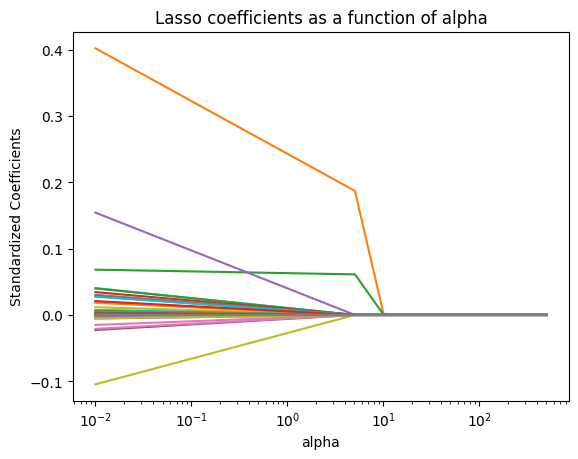

In [105]:
plot_lasso(alphas, lst_coefs, 0)

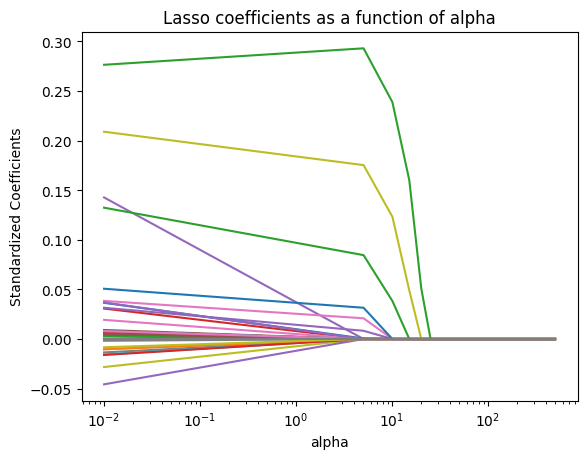

In [106]:
plot_lasso(alphas, lst_coefs, 1)

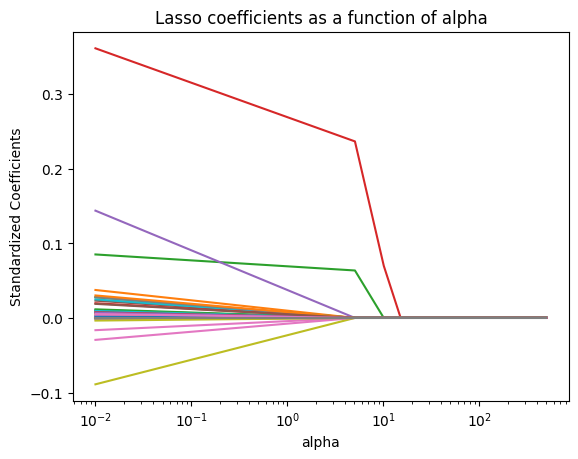

In [107]:
plot_lasso(alphas, lst_coefs, 2)

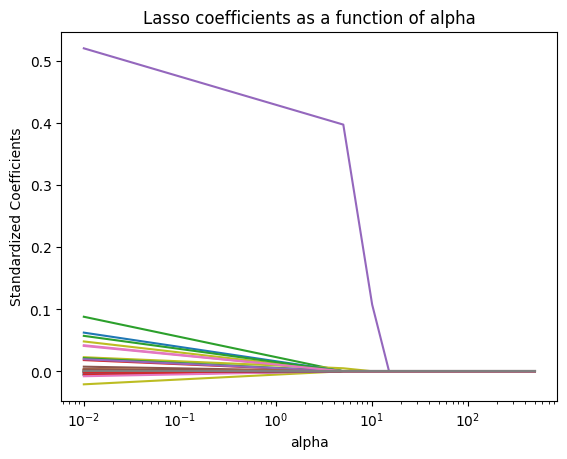

In [108]:
plot_lasso(alphas, lst_coefs, 3)

In [53]:
%%time
from sklearn.linear_model import MultiTaskLassoCV

# Lasso with 5 fold cross-validation
model = MultiTaskLassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(x_train, y_train)

CPU times: user 56min 19s, sys: 18min 14s, total: 1h 14min 34s
Wall time: 11min 40s


MultiTaskLassoCV(cv=5, max_iter=10000, random_state=0)

In [55]:
model.alpha_

1991341338.8000252

In [56]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(x_train, y_train)

Lasso(alpha=1991341338.8000252)

In [58]:
print(list(zip(lasso_best.coef_, x_train)))

[(array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]), 'IdPlayer'), (array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'target1_shift_1'), (array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]), 'target2_shift_1'), (array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'target3_shift_1')]


In [59]:
y_pred_lasso_best = pd.DataFrame(lasso_best.predict(x_test), columns=TARGET_COLS)

In [60]:
evals_df = evals_df.append({'model': 'lasso_best', **evaluate_mae(y_test, y_pred_lasso_best)}, ignore_index=True)

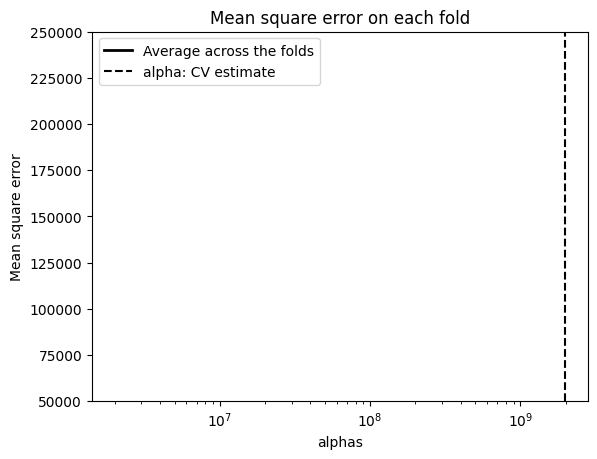

In [61]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax);

In [62]:
evals_df

,model,target1,target2,target3,target4
0,naive,0.794010,1.349561,0.626269,0.809013
1,mean,0.943662,2.253810,0.954913,1.021249
2,lasso,0.749040,1.402901,0.676788,0.760047
3,multitask LASSO,0.748527,1.503057,0.672377,0.789836
4,lasso_best,1.132658,2.746612,1.070628,1.475053
